# Defining all libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -v 'nibabel==3.2.1'
!pip install tensorflow_addons
import os
import random
import re
import scipy
import scipy.misc
import numpy as np
from skimage import exposure
import cv2
import nibabel as nib
from nilearn.image import resample_img
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import keras.layers as tfl
import keras.models as models
import tensorflow.python.keras.backend as K
from zipfile import ZipFile
plt.set_cmap('gray')
%matplotlib inline

# Image directory and size parameters

In [ ]:
HOME_DIR = os.path.join("/content/drive/MyDrive/PROJECT/Segmentation/")
MODEL_DIR = os.path.join(HOME_DIR,"Models")
LOG_DIR = os.path.join(HOME_DIR,"Logs")
PLOT_DIR = os.path.join(HOME_DIR,"Plots")
IMAGE_DIR = os.path.join(HOME_DIR,"Images")
DATA_DIR = os.path.join(HOME_DIR,"Dataset")
NII_DIR = os.path.join(DATA_DIR, "CT-ORG")

TRAIN_DIR = os.path.join(NII_DIR, "train")
TEST_DIR = os.path.join(NII_DIR, "test")

MASKS_NII = "MASKS_NII/"
PATIENT_NII = "PATIENT_NII/"
TRAIN = "train/"
TEST = "test/"

In [ ]:
IMG_DTYPE = float
MASK_DTYPE = np.uint8
image_size = 256
batch_size = 8
epochs = 10
IMG_DIM=(image_size,image_size,300)

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
directory_to_move =  PATIENT_NII
desired_scans_path = os.path.join(TRAIN_DIR, PATIENT_NII)
desired_masks_path = os.path.join(TRAIN_DIR, MASKS_NII)

test_scans_path = os.path.join(TEST_DIR, PATIENT_NII)
test_masks_path = os.path.join(TEST_DIR, MASKS_NII)

# Utility functions

In [ ]:
def getIDFromName(array):
    numbers = []
    for string in array:
        match = re.search(r'\d+', string)
        if match:
            number = int(match.group())
            numbers.append(number)
    return numbers


In [ ]:
def show_nifti_slices(slices):
  """ Function to display row of image slices """
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [ ]:
## Training Ids

train_list = []
for file in os.listdir(os.path.join(desired_scans_path)):
        train_list.append(file)

print(len(train_list))

val_data_size = len(train_list)//5

valid_ids = getIDFromName(train_list[:val_data_size])
train_ids = getIDFromName(train_list[val_data_size:])

print(train_ids)

In [ ]:
CLASSES = ['background', 'liver', 'bladder','lung', 'kidneys', 'bones' , 'brain']
num_classes = len(CLASSES)

labels = {}
for i in range(len(CLASSES)):
    labels[i] = CLASSES[i]

print(labels)


# Pre-processing Methods

## Histogram Equalization

In [ ]:
def equalize_histogram(image):
    image_equalized = exposure.equalize_hist(image)
    return image_equalized

# Example usage
sample_image_path = os.path.join(TRAIN_DIR,PATIENT_NII, "volume-23.nii.gz")
sample_image = nib.load(sample_image_path).get_fdata()
equalized_image = equalize_histogram(sample_image)
plt.imshow(equalized_image[:,:,50], cmap='gray')
plt.title("Equalized Image")
plt.show()

## Normalize

In [ ]:
def normalize_image(img):
    """ Normalize image values to [0,1] """
    norm = cv2.normalize(img, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm

## Resizing

In [ ]:
from skimage.transform import resize

def resize_image(image, target_shape=(128, 128, 128)):
    resized_image = resize(image, target_shape, mode='constant')
    return resized_image

# Example usage
sample_image_path = os.path.join(TRAIN_DIR, PATIENT_NII, "volume-23.nii.gz")
sample_image = nib.load(sample_image_path).get_fdata()
resized_image = resize_image(sample_image)
plt.imshow(resized_image[:,:,50], cmap='gray')
plt.title("Resized Image")
plt.show()


# Dataloader

## Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data for Keras based on NIfTI files for medical segmentation.

    :param image_paths: List of paths to the image files.
    :type image_paths: list
    :param mask_paths: List of paths to the mask files.
    :type mask_paths: list
    :param batch_size: Number of samples per gradient update.
    :type batch_size: int
    :param dim: Tuple indicating dimensions of the input data. E.g., (256, 256, Z) where Z can vary.
    :type dim: tuple
    :param n_classes: Number of segmentation classes.
    :type n_classes: int
    :param shuffle: Whether to shuffle the data after each epoch, defaults to True.
    :type shuffle: bool, optional
    """
    def __init__(self,  list_IDs, path, dim, batch_size=batch_size, n_classes = num_classes , shuffle=True):
        self.path = path
        self.list_IDs = list_IDs
        self.image_paths = []
        self.mask_paths = []
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.__get_paths__()
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __get_paths__(self):
      image_paths=[]
      mask_paths=[]
      for ID in self.list_IDs:
        x_path = os.path.join(self.path, PATIENT_NII,  'volume-{}.nii.gz'.format(ID) )
        y_path = os.path.join(self.path, MASKS_NII, 'labels-{}.nii.gz'.format(ID) )

        image_paths.append(x_path)
        mask_paths.append(y_path)

      self.image_paths = image_paths
      self.mask_paths = mask_paths

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in indexes]
        batch_mask_paths = [self.mask_paths[k] for k in indexes]
        X, y = self.__data_generation(batch_image_paths, batch_mask_paths)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_mask_paths):
        X = np.empty((self.batch_size, *self.dim, 3))
        y = np.empty((self.batch_size, *self.dim, self.n_classes))

        for j, (img_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            # Load NIfTI file
            img_nifti = nib.load(img_path)
            mask_nifti = nib.load(mask_path)

            # Get the image and mask data
            img_data = img_nifti.get_fdata()
            mask_data = mask_nifti.get_fdata()

            # Preprocess the data if needed (e.g. normalization, resizing, etc.)
            i_data_dim = mask_data.shape[2]
            img_data = np.array(img_data.astype(IMG_DTYPE))
            img_data = scipy.ndimage.zoom(img_data, [1,1,self.dim[2]/i_data_dim])
            img_data_copy = np.empty((image_size, image_size, img_data.shape[2],3))
            #print('shape', img_data.shape)

            mask_data = np.array(mask_data.astype(IMG_DTYPE))
            mask_data = scipy.ndimage.zoom(mask_data, [1,1,self.dim[2]/i_data_dim])
            mask_data_copy = np.empty((image_size, image_size, mask_data.shape[2]))
            for i in range(mask_data.shape[2] - 1):
              i_mask_data = np.array(Image.fromarray(mask_data[:,:,i]).resize([image_size, image_size])).astype(IMG_DTYPE)
              mask_data_copy[:,:,i] = i_mask_data
              i_img_data = np.array(Image.fromarray(img_data[:,:,i]).resize([image_size, image_size])).astype(IMG_DTYPE)
              i_img_data = np.stack((i_img_data,)*3, axis=-1)
              img_data_copy[:,:,i] = i_img_data #np.stack([i_img_data, i_img_data, i_img_data], axis=-1)

            # One-hot encode the mask
            mask_data_encoded = np.zeros((*mask_data_copy.shape[:i_data_dim], self.n_classes))
            for c in range(self.n_classes):
                mask_data_encoded[mask_data_copy == c, c] = 1

            # Assign the data
            X.resize((self.batch_size, *img_data_copy.shape ))
            y.resize((self.batch_size, *mask_data_copy.shape , self.n_classes))

            X[j,] = img_data_copy
            y[j,] = mask_data_encoded

        return X, y


## Instantiate the Generators

In [ ]:
train_gen = DataGenerator(train_ids, TRAIN_DIR, dim=IMG_DIM )
valid_gen = DataGenerator(valid_ids, TRAIN_DIR, dim=IMG_DIM )

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

## Displaying Images in the train dataset

In [ ]:

idx = 0

x, y = train_gen.__getitem__(0)

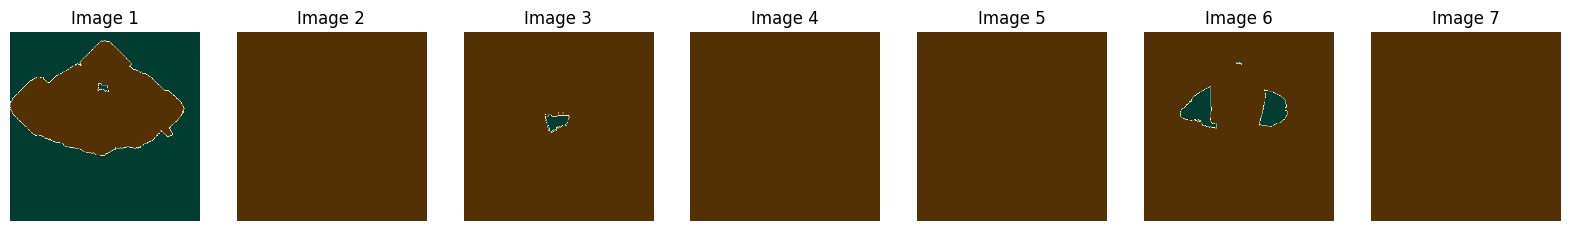

In [ ]:
# Number of separate images (channels)
num_images = x.shape[0]

# Slices to visualize for each image. Example: middle slice
slice_idx = x.shape[3] // 2

# Plot each image slice
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

for i in range(num_classes):
    axes[i].imshow(y[4, :, :, 60, i].T, cmap='BrBG', origin="lower")
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.show()

# Model architecture

## ResUnet model

In [ ]:
"""
- Author nikhilroxtomar
- Date 10/4/2019 (DD/MM/YYYY)
- Link https://github.com/nikhilroxtomar/Deep-Residual-Unet
"""

def bn_act(x, act=True):
    x = tfl.BatchNormalization()(x)
    if act == True:
        x = tfl.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tfl.Conv3D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    conv = tfl.Conv3D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = tfl.Conv3D(filters, kernel_size=(1, 1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = tfl.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = tfl.Conv3D(filters, kernel_size=(1, 1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = tfl.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tfl.UpSampling3D((2, 2, 2))(x)
    c = tfl.Concatenate()([u, xskip])
    return c


In [ ]:
def ResUNet(num_class):
    f = [16, 32, 64, 128, 256]
    inputs = tfl.Input((image_size, image_size, None, 3))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = tfl.Conv3D(num_class, (1, 1, 1), padding="same", activation="softmax")(d4)
    model = models.Model(inputs, outputs)

    return model


# Model Training

## Tensorboard initiation

In [ ]:
#Visualize on tensorboard
%tensorboard --logdir /content/drive/MyDrive/Cours/PROJECT/Segmentation/Logs

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

logdir = os.path.join(LOG_DIR, 'log_' + datetime.now().strftime("%Y-%m-%d_%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    write_graph=True,
    write_images=True,
    )

## Compilation

In [ ]:
def dice_score_generalized(y_true, y_pred, smooth=1.0):
    """
    Dice coefficient for multi-class segmentation.
    """

    # Shape of y_true and y_pred: (batch_size, h, w, num_classes)
    # Shape of classes_dice: (batch_size, num_classes)
    numerator = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    classes_dice = (2. * numerator + smooth) / (denominator + smooth)

    # Average over classes and batch
    return tf.reduce_mean(classes_dice)


def dice_loss_generalized(onehots_true, logits):
    loss = 1.0 - dice_score_generalized(onehots_true, logits)
    return loss

In [ ]:
initial_learning_rate = 0.0001
decay_steps =  train_gen.__len__() * epochs #train_steps
alpha=0.0
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps, alpha=alpha)
updatelr = tf.keras.callbacks.LearningRateScheduler(cosine_decay, verbose=1)

In [ ]:
model = ResUNet(num_class=num_classes)
adam = tf.keras.optimizers.experimental.AdamW(weight_decay=0.004, learning_rate=cosine_decay)
model.compile(optimizer=adam, loss=dice_loss_generalized, metrics=["acc", dice_score_generalized], run_eagerly=True)
model.summary()

## Training

In [ ]:
history = model.fit(train_gen,
                  validation_data=valid_gen,
                  steps_per_epoch=train_steps,
                  validation_steps=valid_steps,
                  epochs=epochs,
                  callbacks = [updatelr])

## Saving Model

In [ ]:
model_path = os.path.join(MODEL_DIR,'mc_model_' + str(epochs) +'e_'  +  datetime.now().strftime("%Y-%m-%d_%H%M%S")+ '.h5')
model_weight_path = os.path.join(MODEL_DIR,'mc_model_weight_' + str(epochs) + datetime.now().strftime("%Y-%m-%d_%H%M%S") + '.h5')
model.save(model_path)
model.save_weights(model_weight_path)


# Model Evaluation

In [ ]:
fname = os.path.join(PLOT_DIR, 'metrics_vs_epoch_' + str(epochs)  +'e_'  + datetime.now().strftime("%Y-%m-%d_%H%M%S") + '.png')

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

plt.plot(history.epoch, history.history['loss'], label='Loss', lw=3)
plt.plot(history.epoch, history.history['acc'], label='Accuracy', lw=3)
plt.plot(history.epoch, history.history['val_loss'], label='val_loss', lw=3)
plt.plot(history.epoch, history.history['dice_score_generalized'], label='dice_score_generalized', lw=3)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.savefig(fname, dpi=300, bbox_inches='tight');

In [ ]:
fname_lr = os.path.join(PLOT_DIR, 'metrics_vs_lr_' + str(epochs) +'e_' + datetime.now().strftime("%Y-%m-%d_%H%M%S") + '.png')

plt.plot(history.history['lr'], history.history['val_loss'], label='val_loss', lw=3)
plt.plot(history.history['lr'], history.history['dice_score_generalized'], label='dice_score_generalized', lw=3)


plt.title('Classification loss as a function of increasing learning rate for ' + str(epochs)  + ' epochs', size=20)
plt.xlabel('learning rate', size=14)
plt.legend()

plt.savefig(fname_lr, dpi=300, bbox_inches='tight');